# 25. Denoising AutoEncoder

In [1]:
import torch
import torch.nn.init
import torch.nn as nn
import torch.optim as optim


import torchvision
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 25.1 Preparing SVHN Data

In [3]:
svhn_train = dsets.SVHN(root='data/',
                       split='train',
                       transform=transforms.ToTensor(),
                       download=True)

svhn_test = dsets.SVHN(root='data/',
                       split='test',
                       transform=transforms.ToTensor(),
                       download=True)

Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


In [4]:
batch_size = 100

train_loader  = torch.utils.data.DataLoader(dataset=svhn_train,
                                            batch_size=batch_size,
                                            shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=svhn_test,
                                          batch_size=1,
                                          shuffle=False)

In [5]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

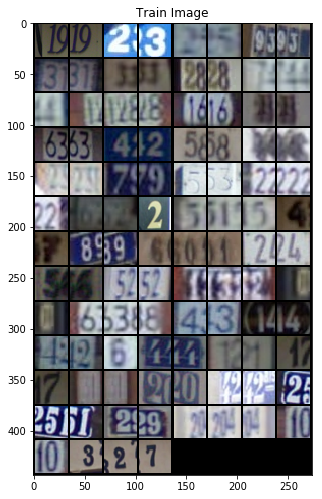

In [6]:
images, labels = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images, normalize=True), "Train Image")

In [7]:
images.shape

torch.Size([100, 3, 32, 32])

## 25.2 Define Model

In [8]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3,16,5),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16,32,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(32),
            nn.Conv2d(32,64,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2) #64*4*4
        )
        
    def forward(self, x):
        z = self.encoder(x)
        
        return z

In [9]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64,32,4,stride=2,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32,16,4,stride=2,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16,3,4,stride=2,padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, z):
        out = self.decoder(z)
        
        return out

In [10]:
E = Encoder().cuda()
D = Decoder().cuda()

## 25.3 Model Training

In [11]:
loss = nn.MSELoss()
optimizer = optim.Adam(list(E.parameters()) + list(D.parameters()), lr=0.001)

In [12]:
num_epochs = 5

In [13]:
for epoch in range(num_epochs):
    
    total_batch = len(svhn_train) // batch_size
    
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        
        X = batch_images.cuda()
        
        noise = torch.randn(X.size())*0.1
        noise = noise.cuda()
        
        noise_X = X + noise
        
        pre = D(E(noise_X))
        cost = loss(pre, X)
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print('Epoch [%d/%d], lter [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, cost.item()))
    
print("Learning Finished!")

Epoch [1/5], lter [100/732], Loss: 0.0424
Epoch [1/5], lter [200/732], Loss: 0.0141
Epoch [1/5], lter [300/732], Loss: 0.0132
Epoch [1/5], lter [400/732], Loss: 0.0122
Epoch [1/5], lter [500/732], Loss: 0.0084
Epoch [1/5], lter [600/732], Loss: 0.0097
Epoch [1/5], lter [700/732], Loss: 0.0081
Epoch [2/5], lter [100/732], Loss: 0.0075
Epoch [2/5], lter [200/732], Loss: 0.0071
Epoch [2/5], lter [300/732], Loss: 0.0074
Epoch [2/5], lter [400/732], Loss: 0.0092
Epoch [2/5], lter [500/732], Loss: 0.0068
Epoch [2/5], lter [600/732], Loss: 0.0080
Epoch [2/5], lter [700/732], Loss: 0.0067
Epoch [3/5], lter [100/732], Loss: 0.0065
Epoch [3/5], lter [200/732], Loss: 0.0105
Epoch [3/5], lter [300/732], Loss: 0.0067
Epoch [3/5], lter [400/732], Loss: 0.0087
Epoch [3/5], lter [500/732], Loss: 0.0062
Epoch [3/5], lter [600/732], Loss: 0.0075
Epoch [3/5], lter [700/732], Loss: 0.0062
Epoch [4/5], lter [100/732], Loss: 0.0060
Epoch [4/5], lter [200/732], Loss: 0.0060
Epoch [4/5], lter [300/732], Loss:

## 25.4 Test Model

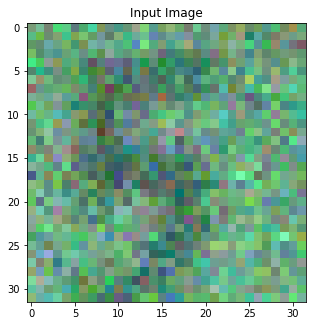

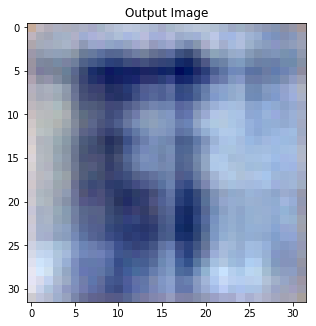

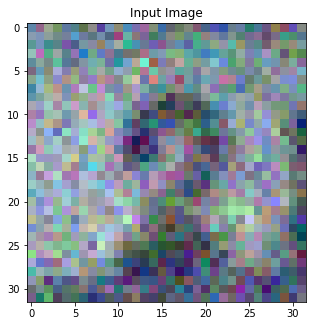

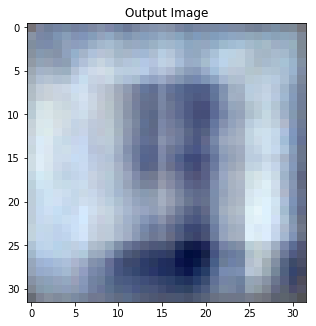

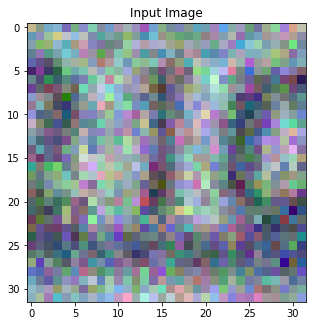

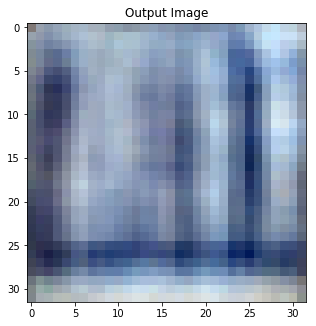

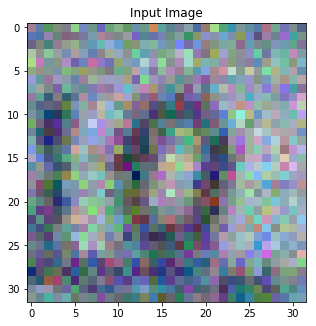

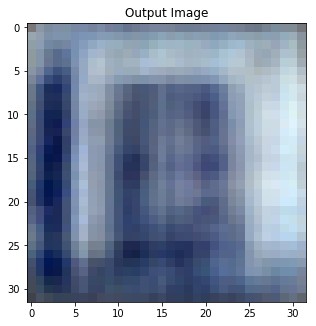

In [14]:
E.eval()
D.eval()

for n, (images, labels) in enumerate(test_loader):
    
    images = images.cuda()
    
    noise = torch.randn(images.size())*0.1
    noise = noise.cuda()
    
    noise_images = images + noise
    
    imshow(torchvision.utils.make_grid(noise_images.data.cpu(), normalize=True), "Input Image")
        
    outputs = D(E(noise_images))
    
    imshow(torchvision.utils.make_grid(outputs.data.cpu(), normalize=True), "Output Image")
    
    if n > 2 : break